In [1]:
from gammapy_bkg2 import *
from gammapy.maps import MapAxis
from gammapy.datasets import (MapDataset, FluxPointsDataset)
from gammapy.makers import (MapDatasetMaker, SafeMaskMaker, DatasetsMaker, FoVBackgroundMaker, RingBackgroundMaker)
from gammapy.modeling.models import (SkyModel, PowerLawSpectralModel, create_crab_spectral_model)
from gammapy.modeling import Fit
from gammapy.estimators import (ExcessMapEstimator, FluxPointsEstimator)
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import os
import json
import yaml
from tqdm import tqdm

Gammapy support for parallelisation with ray is still a prototype and is not fully functional.


# Prerequisite

- Prepare the source run information dictionary using prepare_run_dict.py.

In [2]:
srcinfo = load_src_info('Crab')
ds = DataStore.from_dir(os.environ['DL3DIR'])

In [3]:
srcinfo[0]

{'run_id': 64080,
 'epoch': '12s',
 'wobble': 0.5,
 'elevation': 78.96195186936647,
 'azimuth': 145.11192484191756,
 'current': 8.01532711856992,
 'duration': 1201.0}

# Select the source runs.

In [4]:
ep_range = ['1819w', '19s']
el_range = [55, 75]
wobble = 0.5
srcinfo = [src for src in srcinfo if src['epoch'] in ep_range]
srcinfo = [src for src in srcinfo if src['wobble'] == 0.5]
srcinfo = [src for src in srcinfo if src['elevation'] >= el_range[0]]
srcinfo = [src for src in srcinfo if src['elevation'] <= el_range[1]]

In [5]:
srcinfo[0]

{'run_id': 91024,
 'epoch': '1819w',
 'wobble': 0.5,
 'elevation': 74.67148779396064,
 'azimuth': 125.8974092442715,
 'current': 7.776149641905069,
 'duration': 901.0}

In [6]:
len(srcinfo)

24

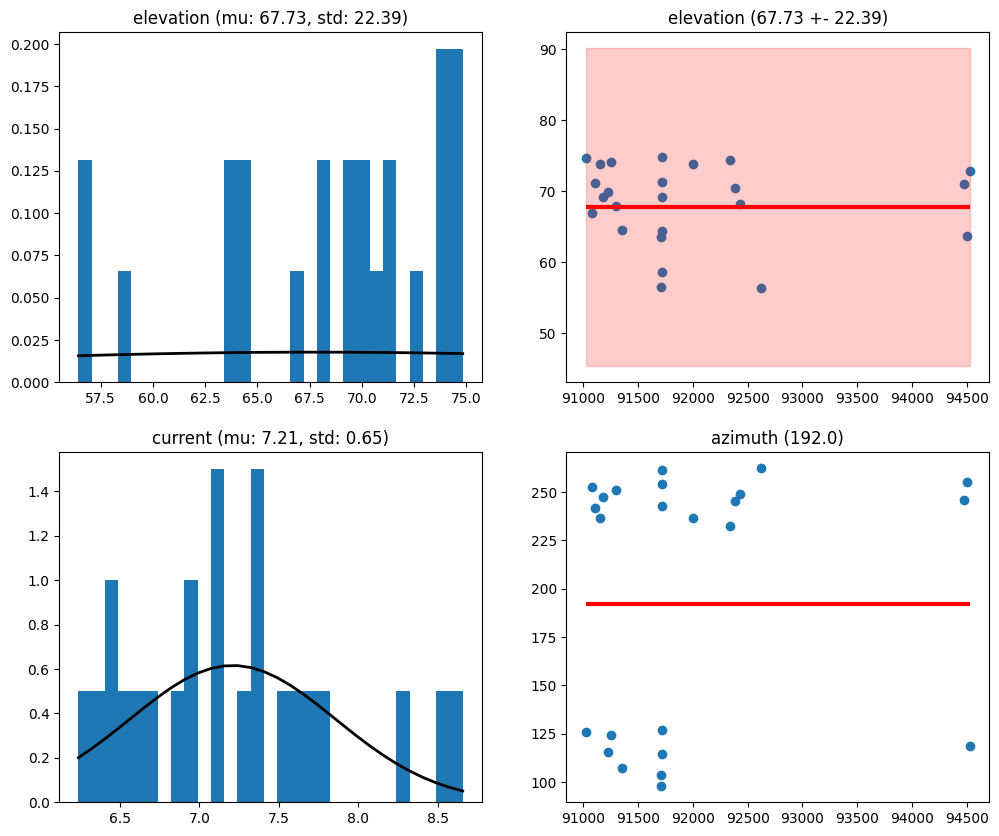

In [7]:
plot_runs_info(srcinfo)

In [8]:
srcobs = get_available_obs(ds, [run['run_id'] for run in srcinfo])

/nevis/tehanu/home/jw3855/.conda/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/utils/decorators.py:837: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)


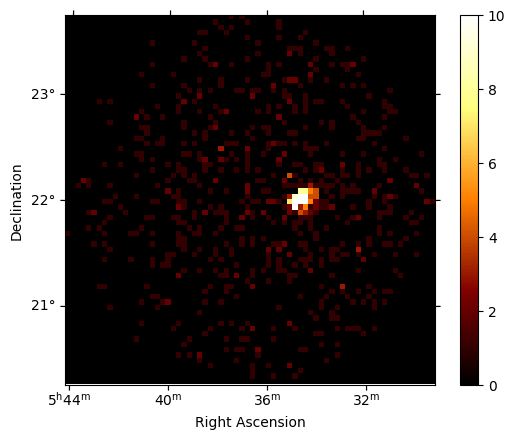

In [9]:
plot_obs(srcobs[0], add_cbar=True, vmax=10)

# Generate acceptance (IRF)

In [10]:
# OA and NA runs need to be analyzed separately.
eginfo = load_eg_info(oa=False, na=False)

In [11]:
# Off and mimic runs will be selected to have as close the elevation as possible to each on run
# and the azimuth within +- 45 deg from the azimuth of the on run.
mimic = MimicDatasetMaker(ds, srcinfo, eginfo, az_thresh=45)

In [12]:
eginfo[0]

{'run_id': 70781,
 'elevation': 76.06222440287746,
 'azimuth': 320.90756776115086,
 'current': 6.380602872411486,
 'duration': 1801.0,
 'source_id': 'BL Lac'}

In [13]:
len(eginfo)

9042

In [14]:
# Select 100 hrs of extragalactic runs to generate background.
# These runs are saved in the 0th entry of the registry of "mimic" object.
mimic.find_mimic_runs(times=100*u.hr.to(u.s)/np.sum([run['duration'] for run in srcinfo]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.56it/s]


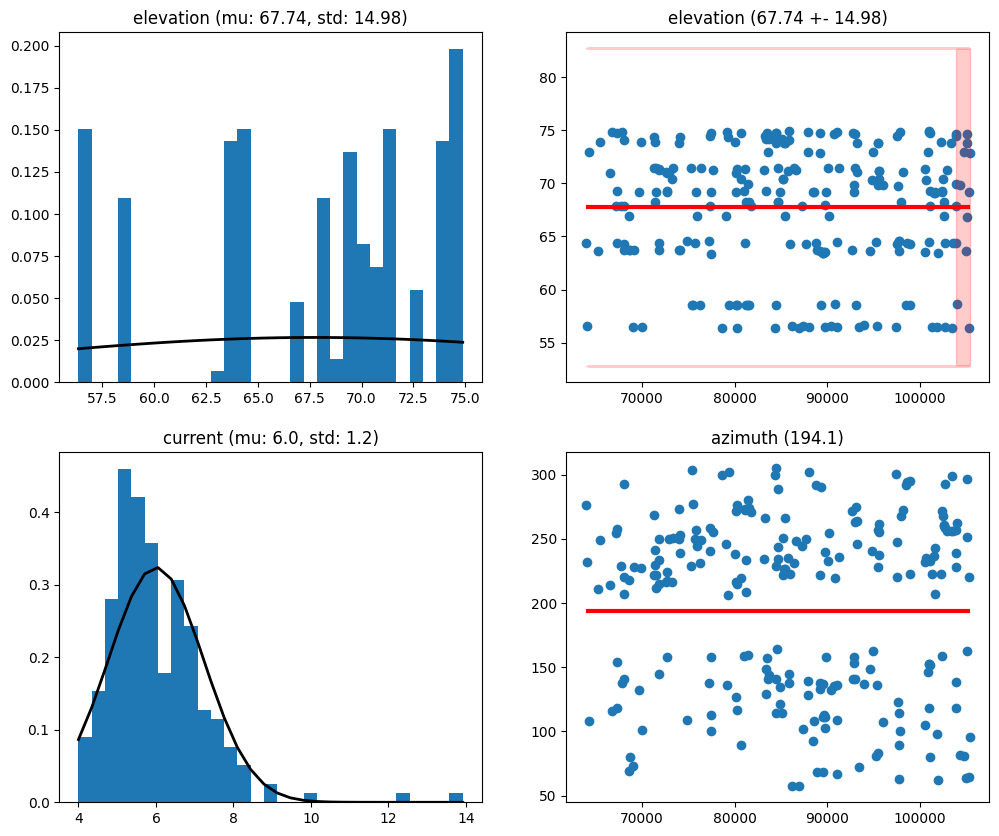

In [15]:
plot_runs_info(mimic.mimic_datasets[0]['information'])

In [16]:
# Excise sources and stars in the field and fill the holes with nearby empty sky patch.
# These emptied runs are saved in the 0th entry of the registry of "mimic" object.
mimic.run_blank_sky(0)

229it [03:23,  1.13it/s]


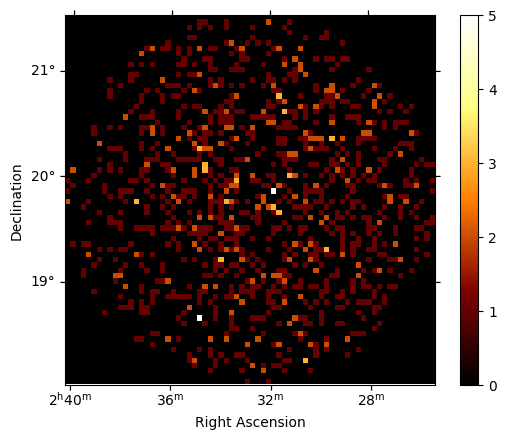

In [17]:
plot_obs(mimic.mimic_datasets[0]['observations'][0], add_cbar=True)

In [18]:
with open(os.environ['VTS_GP']+'/analysis_config.yml', 'r') as f:
    config = yaml.safe_load(f)

In [19]:
config

{'parallel_njobs': 30,
 'theta': 0.1,
 'exclusion_radius': 1.0,
 'offset_max': 1.5,
 'aeff_max': 10,
 'mimic_data': {'az_thresh': 45},
 'energy_binning': {'energy_lo': 0.3, 'energy_hi': 10, 'energy_bins': 6},
 'acceptance': {'hour': 100, 'binsz': 0.1, 'width': 3.5},
 'skymap': {'binsz': 0.05, 'width': 3.5}}

In [20]:
bkg_width = config['acceptance']['width']
bkg_nbin = int(bkg_width / config['acceptance']['binsz'])
fov_lon = MapAxis.from_bounds(-bkg_width/2, bkg_width/2, nbin=bkg_nbin, interp="lin", unit="deg", name="fov_lon")
fov_lat = MapAxis.from_bounds(-bkg_width/2, bkg_width/2, nbin=bkg_nbin, interp="lin", unit="deg", name="fov_lat")

In [21]:
energy_binning = config['energy_binning']
energy_axis = MapAxis.from_energy_bounds(
    energy_binning['energy_lo']*u.TeV, energy_binning['energy_hi']*u.TeV, energy_binning['energy_bins'])

In [22]:
bkgmaker = Background3DModelEstimator(energy_axis, fov_lon, fov_lat)
bkgmaker.run(mimic.mimic_datasets[0]['observations'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:41<00:00,  5.53it/s]


In [23]:
bkgrate = bkgmaker.background_rate

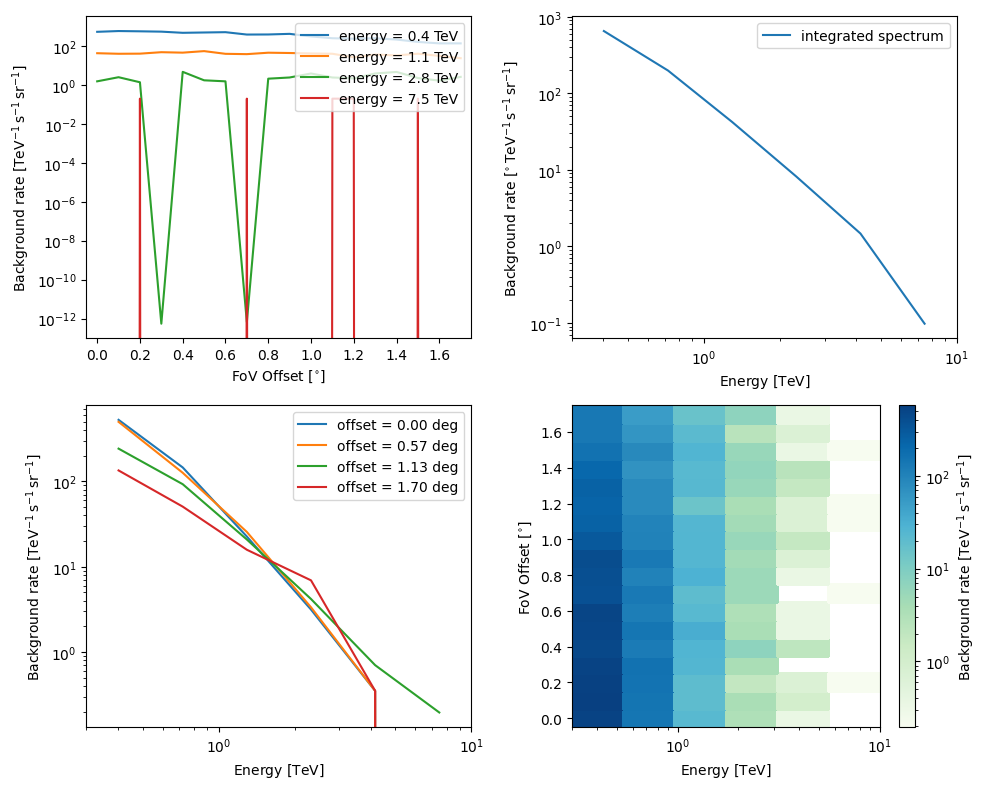

In [24]:
bkgrate.peek()

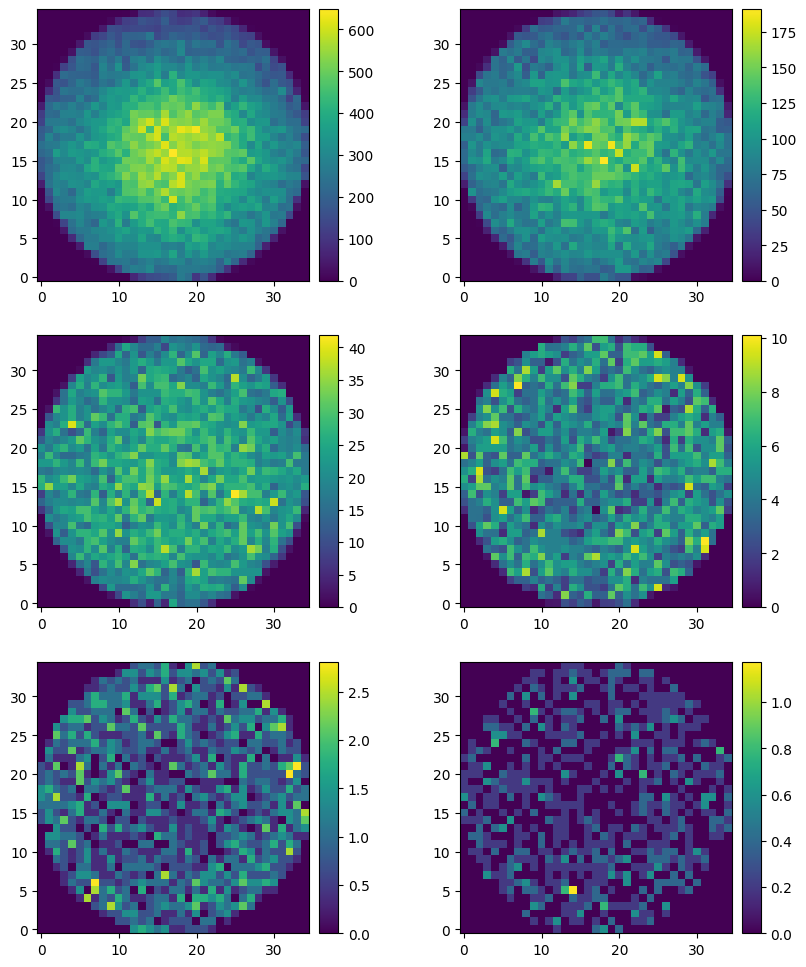

In [25]:
plot_bkg(bkgrate)

In [26]:
# Smooth the background with a Gaussian kernel (sigma = 1 pixel)
# and replace 0's with a small number.
for idx, data in enumerate(bkgrate.data):
    bkgrate.data[idx] = convolve_nonzero(data)

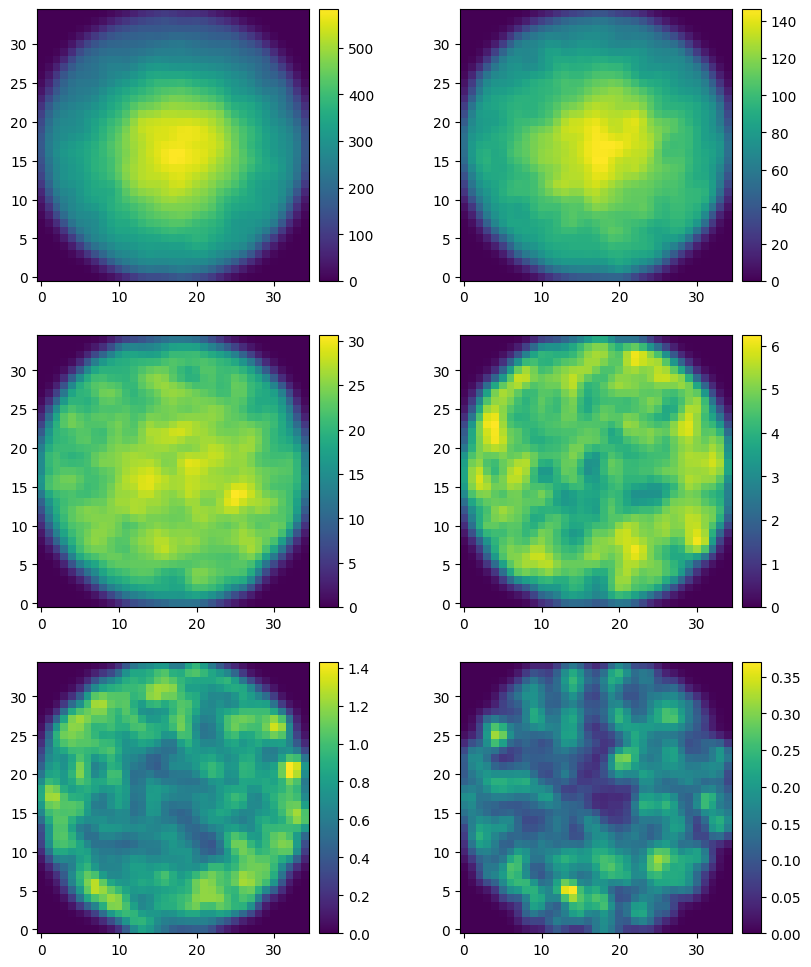

In [27]:
plot_bkg(bkgrate)

In [28]:
# Write the background into a fits file if needed for future use.
bkgrate.write('Crab_test.bkg', overwrite=True)

In [29]:
# Load the background onto the source observations.
for idx, obs in tqdm(enumerate(srcobs)):
    srcobs[idx] = obs.copy(in_memory=True, events=select_gammas(obs), bkg=bkgrate)

24it [00:26,  1.10s/it]


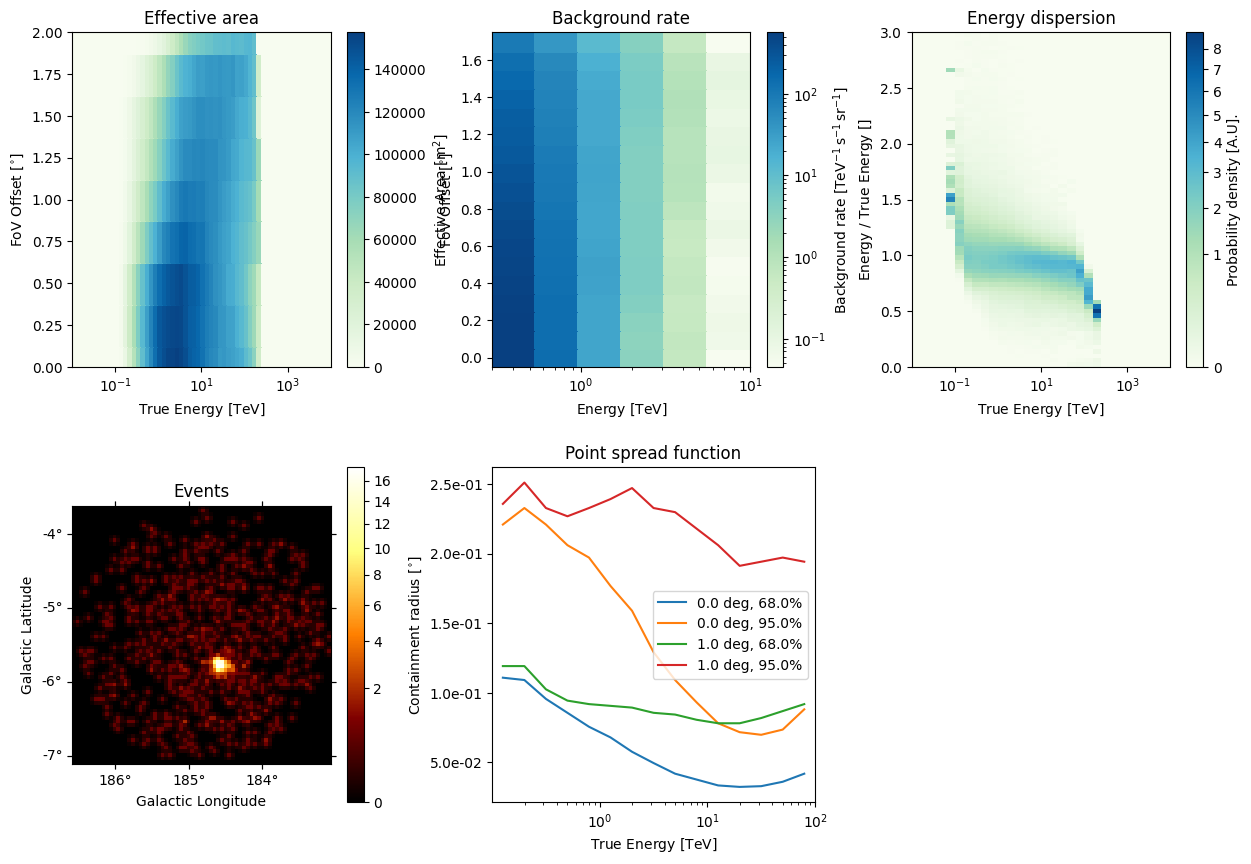

In [30]:
srcobs[0].peek()

# Ring background method

In [31]:
skydir = srcobs[0].target_radec

In [32]:
# Prepare Geom object and exclusion mask (source exclusion r = 0.4, star r = 0.3 by default)
# with the energy axis for 1D (spectral) analysis. 
geom = WcsGeom.create(
    binsz=config['skymap']['binsz'], frame='icrs', axes=[energy_axis], skydir=skydir, width=config['skymap']['width'])
exclusion_mask_1d = prepare_mask(geom, skydir)

In [33]:
# Prepare Geom object and exclusion mask without the energy axis for 2D (imaging) analysis. 
geom_image = geom.to_image().to_cube([energy_axis.squash()])
exclusion_mask_2d = prepare_mask(geom_image, skydir)

<WCSAxes: >

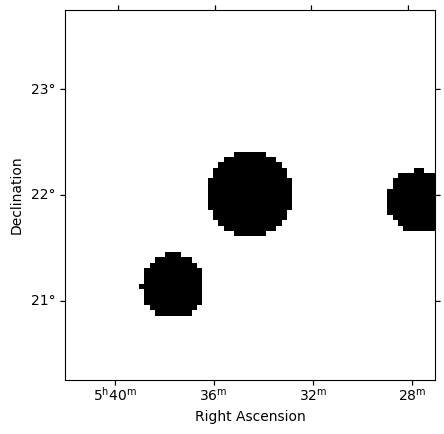

In [34]:
exclusion_mask_2d.plot()

In [35]:
map_dataset_maker = MapDatasetMaker()
safe_mask_maker = SafeMaskMaker(methods=['aeff-max','offset-max'],
                                aeff_percent=config['aeff_max'], offset_max=config['offset_max']*u.deg)
datasets_maker = DatasetsMaker([map_dataset_maker, safe_mask_maker],
                               stack_datasets=False, n_jobs=config['parallel_njobs'],
                               cutout_mode='trim', cutout_width=config['offset_max']*2*u.deg)

In [36]:
energy_axis_true = srcobs[0].edisp.axes['energy_true']

In [37]:
on_region = prepare_on_region(SkyCoord.from_name('Crab'), config['theta']*u.deg)

In [38]:
ring_in, ring_width = [0.4, 0.1]*u.deg

In [39]:
stacked = MapDataset.create(geom, energy_axis_true=energy_axis_true, name='stacked')
datasets = datasets_maker.run(stacked, srcobs)

In [40]:
spec_on_off, image_on_off = run_rbm(
    geom, geom_image, energy_axis_true, ring_in, ring_width,
    exclusion_mask_1d, exclusion_mask_2d, on_region, datasets)

/nevis/tehanu/home/jw3855/.conda/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


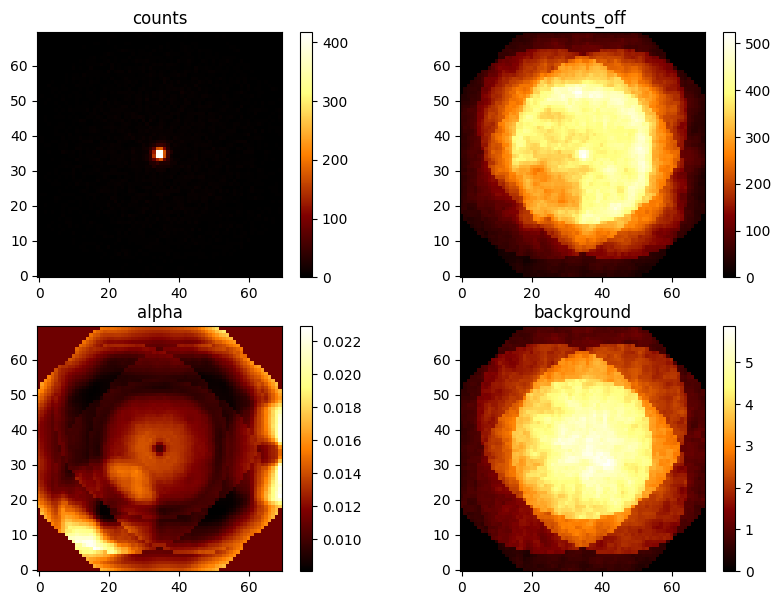

In [41]:
plot_onoff(image_on_off)

/nevis/tehanu/home/jw3855/.conda/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


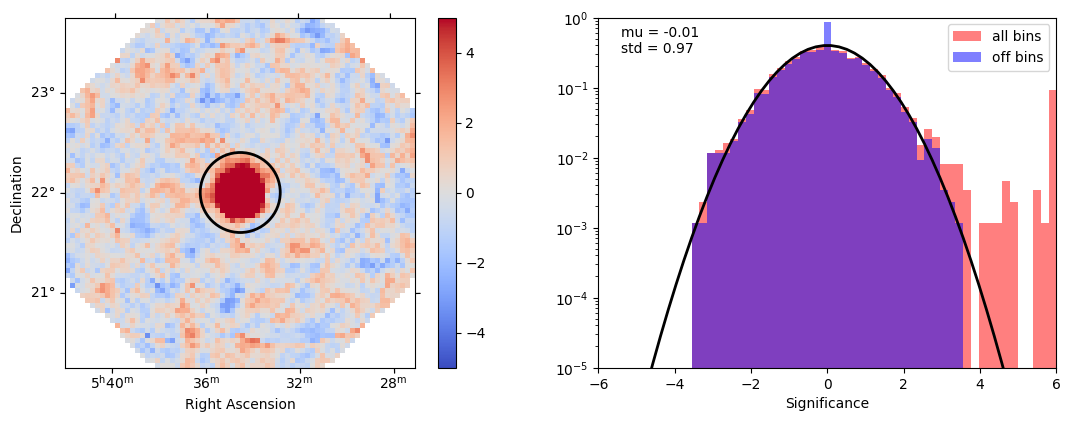

In [42]:
estimator = ExcessMapEstimator(correlation_radius=config['theta']*u.deg, correlate_off=False)
lima_maps = estimator.run(image_on_off)
plot_sig(lima_maps['sqrt_ts'], exclusion_mask_2d, 0.4*u.deg)

In [43]:
# Initial spectral model for the source
spec_model = PowerLawSpectralModel(index=2.4, amplitude=1e-12/u.TeV/u.s/u.cm**2, reference=1*u.TeV)
spec_on_off.models = SkyModel(spectral_model=spec_model)

In [44]:
fit = Fit()
fit_result = fit.run(datasets=spec_on_off)

In [45]:
print(fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 105
	total stat : 15.95

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [46]:
display(spec_on_off.models[0].parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.4309e+00,,2.696e-02,nan,nan,False,False,
spectral,amplitude,3.8105e-11,TeV-1 s-1 cm-2,7.987e-13,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


In [47]:
energy_edges = geom.axes['energy'].edges
fpe = FluxPointsEstimator(energy_edges=energy_edges, selection_optional='all', fit=fit,
                          n_jobs=config['parallel_njobs'], parallel_backend='multiprocessing')
flux_points = fpe.run(datasets=spec_on_off)

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


In [48]:
flux_points.to_table('e2dnde')

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.40181654661953553,0.3,0.5381884571241647,5.345586725483326e-11,1.663061665696835e-12,1.6798091352373102e-12,1.6464728828511e-12,5.513581635400058e-11,5088.830377825099,71.336038422561,1104.9972032901048,1068.6605,7.079506758600473e-09,False,1105.0,True,0.2 .. 4.999999999999999,1490.307295580562 .. 5528.9038299814565
0.7208434242404262,0.5381884571241647,0.9654893846056297,4.599470325227435e-11,1.5748195115493607e-12,1.5926391015921365e-12,1.5573940709998679e-12,4.7591680582669437e-11,4849.24020054112,69.63648613005341,886.917966019247,869.8513,7.589005690533668e-06,False,887.0,True,0.2 .. 4.999999999999999,1388.8889531203386 .. 3813.8934095298464
1.2931653677335158,0.9654893846056297,1.7320508075688772,3.756071362375576e-11,1.6550371422857574e-12,1.6791326980953733e-12,1.6311208722984696e-12,3.9240007572960864e-11,3242.98593227074,56.94722058424572,527.9977616982374,521.5207,9.489667718298733e-09,False,528.0,True,0.2 .. 4.999999999999999,889.6488373568882 .. 2105.2242483985938
2.3198889135563467,1.7320508075688772,3.1072325059538586,2.660151966204496e-11,1.6869197478727097e-12,1.7224784094613662e-12,1.6517707951098655e-12,2.8324268843553186e-11,1685.1679303678347,41.050796951677256,252.99744733858236,250.83398,2.57577994489111e-08,False,253.0,True,0.2 .. 4.999999999999999,396.931910145634 .. 1189.2572201849093
4.161791450287817,3.1072325059538586,5.574255561017864,1.7445022910570972e-11,1.7602791447415058e-12,1.8197800252250183e-12,1.701789171905897e-12,1.9264962147932498e-11,747.1692981569148,27.334397709788938,98.99910041465276,98.60805,8.1746520663728e-09,False,99.0,True,0.2 .. 4.999999999999999,132.4722971215739 .. 616.8321435654843
7.466093731676468,5.574255561017864,10.000000000000002,1.177501193131393e-11,2.065605395116889e-12,2.187318670917602e-12,1.9472874169824186e-12,1.3962399761104703e-11,224.39057260748996,14.979671979302148,32.99980800644138,32.74808,1.1172005542903207e-09,False,33.0,True,0.2 .. 4.999999999999999,36.868947801989805 .. 254.00812527135707


In [49]:
# Compare with the Crab spectrum from HESS
ref_model = create_crab_spectral_model('hess_pl')

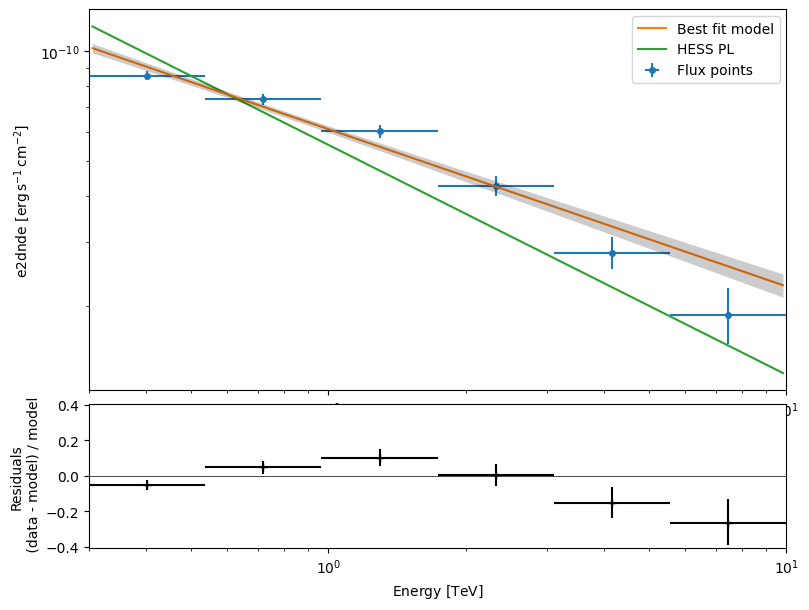

In [50]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=spec_on_off.models)
ax_spec, ax_resid = flux_points_dataset.plot_fit()
ref_model.plot([energy_binning['energy_lo'], energy_binning['energy_hi']]*u.TeV, sed_type='e2dnde',
               ax=ax_spec, label='HESS PL')
ax_spec.legend()

# Field-of-view method

In [51]:
fov_bkg_maker = FoVBackgroundMaker(method='scale', exclusion_mask=exclusion_mask_1d)
for data in tqdm(datasets):
    dataset = fov_bkg_maker.run(data)
    stacked.stack(dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.35it/s]


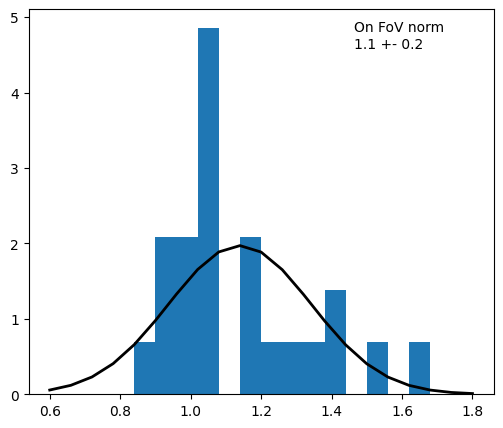

In [52]:
plot_fov([dataset.models[0].spectral_model.norm.value for dataset in datasets], 'On')

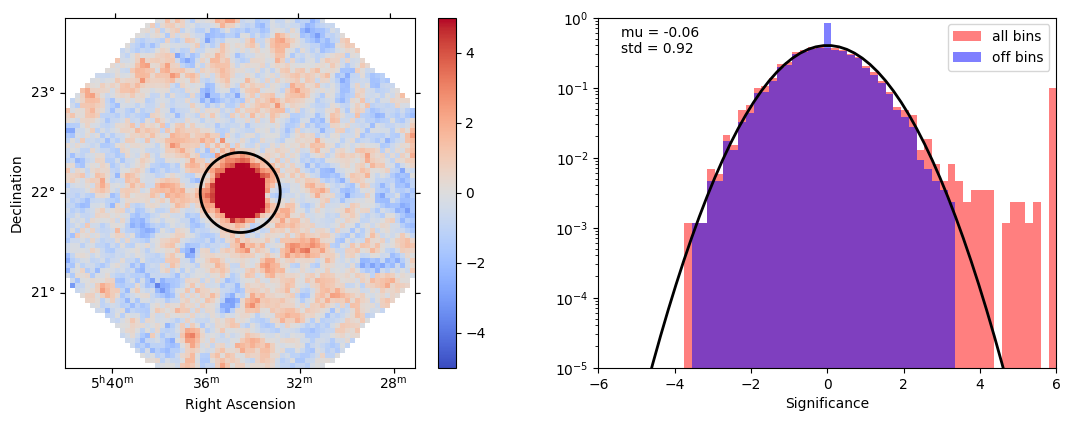

In [53]:
estimator = ExcessMapEstimator(correlation_radius=config['theta']*u.deg, correlate_off=False)
lima_maps = estimator.run(stacked)
plot_sig(lima_maps['sqrt_ts'], exclusion_mask_2d, 0.4*u.deg)

In [54]:
spec_datasets = Datasets()
for dataset in datasets:
    spec_datasets.append(dataset.to_spectrum_dataset(on_region, containment_correction=True))
spec_datasets.models = SkyModel(spectral_model=spec_model)

In [55]:
fit_result = fit.run(datasets=spec_datasets)

In [56]:
print(fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 31
	total stat : -14114.55

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [57]:
display(spec_datasets.models[0].parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.4315e+00,,2.689e-02,nan,nan,False,False,
spectral,amplitude,3.8253e-11,TeV-1 s-1 cm-2,7.995e-13,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


In [58]:
flux_points = fpe.run(datasets=spec_datasets)

Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend


In [59]:
flux_points.to_table('e2dnde')

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[24],float32[24],float64,bool,float64[24],bool,float64[11],float64[11]
0.40181654661953553,0.3,0.5381884571241647,5.373294942494974e-11,1.6642577388886288e-12,1.6809916029491903e-12,1.6476181837863892e-12,5.541408597551411e-11,5721.038965025459,75.6375499670994,35.752900077399204 .. 33.1845384229803,34.69246 .. 32.20042,-6346.773540133538,False,44.0 .. 31.0,True,0.2 .. 4.999999999999999,-4827.258104616958 .. -793.2166843615871
0.7208434242404262,0.5381884571241647,0.9654893846056297,4.616782514872556e-11,1.5747222482120587e-12,1.5925239427584316e-12,1.557308365782178e-12,4.7764661502725745e-11,5642.026996591903,75.11342753856931,27.053258288424765 .. 27.096847572464416,26.606897 .. 26.663273,-4718.133401117338,False,34.0 .. 30.0,True,0.2 .. 4.999999999999999,-3306.389409958371 .. -882.9629036480239
1.2931653677335158,0.9654893846056297,1.7320508075688772,3.7687024934249813e-11,1.6558863373339637e-12,1.6800036574674527e-12,1.631958914313599e-12,3.936719270788335e-11,3871.835027555719,62.22407112649991,15.599665297930635 .. 16.359599853749017,15.445581 .. 16.196316,-2286.592925076086,False,9.0 .. 11.0,True,0.2 .. 4.999999999999999,-1385.8675470364246 .. -171.98251197598978
2.3198889135563467,1.7320508075688772,3.1072325059538586,2.6677057927674707e-11,1.6874128694669849e-12,1.7229773745858987e-12,1.6522402662769412e-12,2.8400207034771096e-11,2081.8687234792105,45.627499640887734,7.310829761689923 .. 7.947541634402308,7.2640457 .. 7.8986335,-713.47492363828,False,5.0 .. 13.0,True,0.2 .. 4.999999999999999,-312.5264142252807 .. 480.9239691920335
4.161791450287817,3.1072325059538586,5.574255561017864,1.7442126973185425e-11,1.7608913479222475e-12,1.820415602258603e-12,1.7023791162163409e-12,1.9262711372441423e-11,876.2017493616038,29.600705217301897,2.768579940644046 .. 3.080149098370276,2.7525573 .. 3.0658941,-102.67064458875319,False,2.0 .. 5.0,True,0.2 .. 4.999999999999999,29.110578655552573 .. 516.8692171586562
7.466093731676468,5.574255561017864,10.000000000000002,1.1822573404454308e-11,2.0675490674011024e-12,2.1893908541287976e-12,1.949105213006633e-12,1.4012035881742663e-11,295.17433381852067,17.180638341415627,0.89462197616592 .. 0.9999628379479432,0.88803905 .. 0.9947491,37.13185948797253,False,1.0 .. 1.0,True,0.2 .. 4.999999999999999,74.46096873727049 .. 291.64042821718215


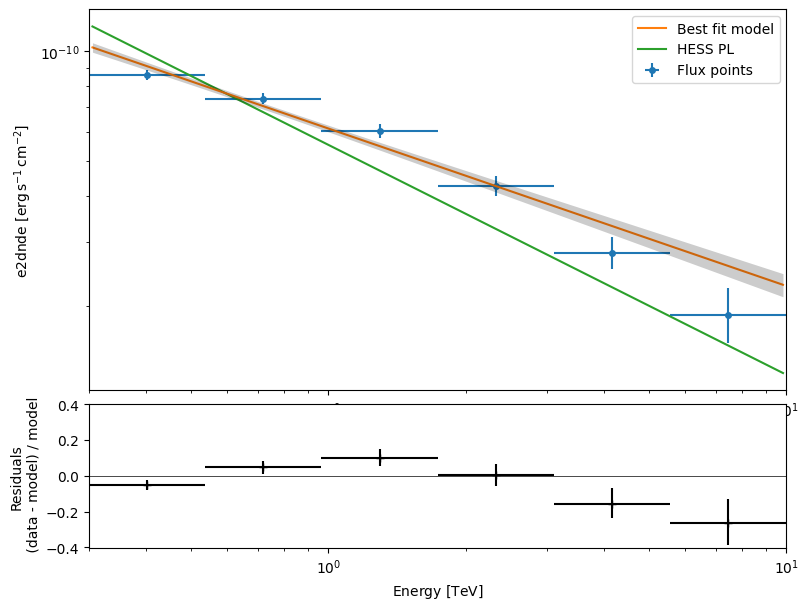

In [60]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=spec_on_off.models)
ax_spec, ax_resid = flux_points_dataset.plot_fit()
ref_model.plot([energy_binning['energy_lo'], energy_binning['energy_hi']]*u.TeV, sed_type='e2dnde',
               ax=ax_spec, label='HESS PL')
ax_spec.legend()

# Generate mimic datasets.

In [61]:
# Select mimic data adding up to the same exposure as the on runs.
# These runs are saved in the 1st entry of the registry of "mimic" object.
# Mimic runs are selected from the extragalactic runs that were not used for background generation.
# Same criteria as selecting off runs are applied.
mimic.find_mimic_runs()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.92it/s]


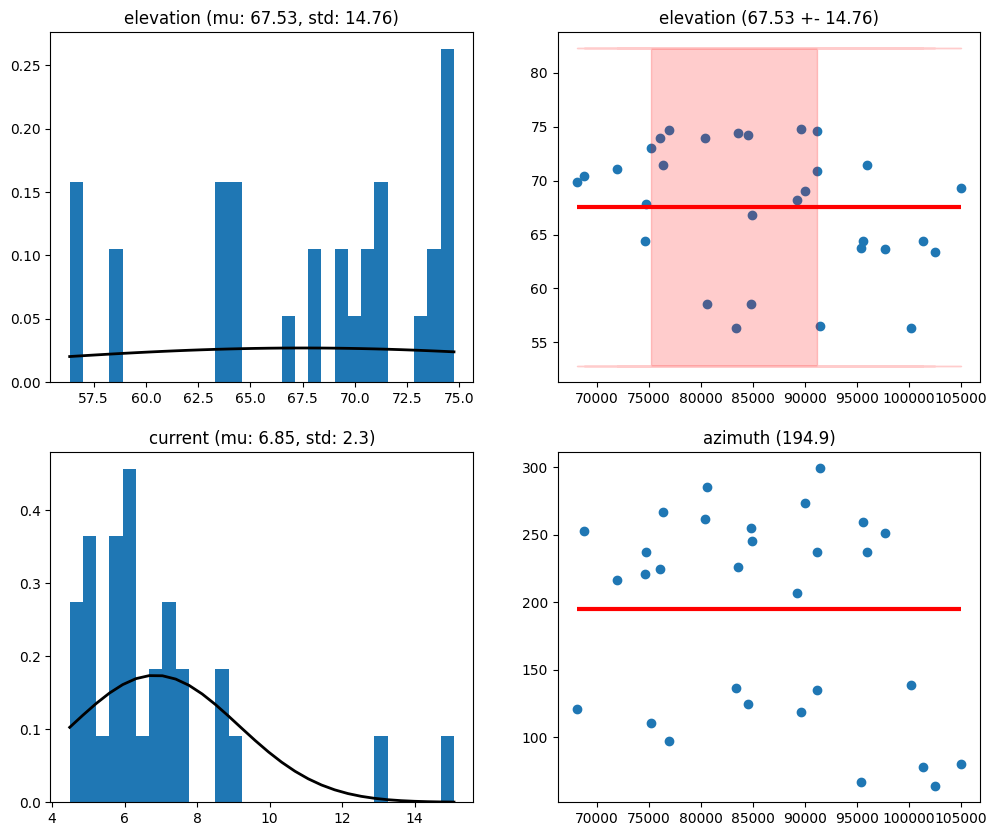

In [62]:
# The elevation and azimuth distribution of mimic runs closely follow those of the on runs.
plot_runs_info(mimic.mimic_datasets[1]['information'])

In [63]:
# Empty the field and shift it as if each mimic run was taken at the same pointing as the corresponding on run.
# These runs are saved in the 1st entry of the registry of "mimic" object.
mimic.run_blank_sky(1)
mimic.run_shifted_sky(1)

30it [00:30,  1.00s/it]
30it [00:10,  2.87it/s]


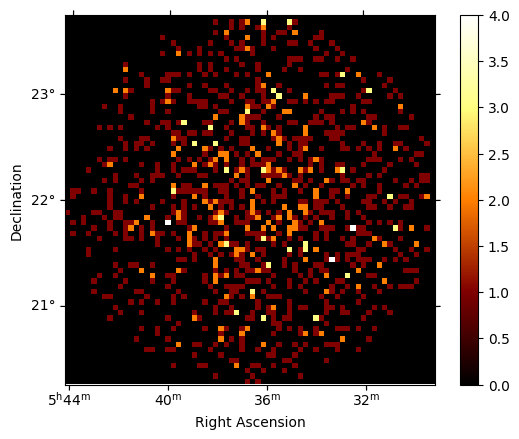

In [64]:
plot_obs(mimic.mimic_datasets[1]['observations'][0], add_cbar=True)

In [65]:
# Load the background onto the mimic observations.
for idx, obs in tqdm(enumerate(mimic.mimic_datasets[1]['observations'])):
    mimic.mimic_datasets[1]['observations'][idx] = obs.copy(
        in_memory=True, events=select_gammas(obs), bkg=bkgrate)

30it [00:00, 32.36it/s]


In [66]:
# One can repeat the same analysis steps as the on runs for the mimic runs.
stacked = MapDataset.create(geom, energy_axis_true=energy_axis_true, name='stacked')
datasets = datasets_maker.run(stacked, mimic.mimic_datasets[1]['observations'])

In [67]:
fov_bkg_maker = FoVBackgroundMaker(method='scale', exclusion_mask=exclusion_mask_1d)
for data in tqdm(datasets):
    dataset = fov_bkg_maker.run(data)
    stacked.stack(dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.81it/s]


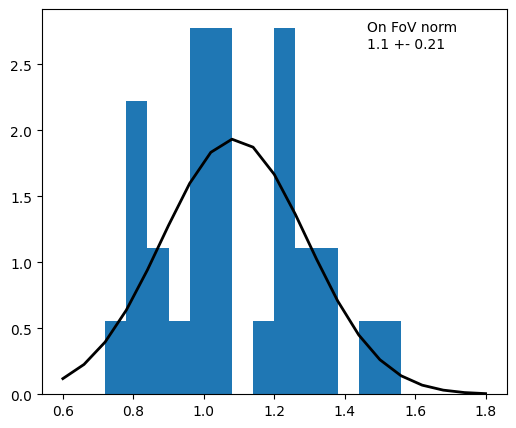

In [68]:
plot_fov([dataset.models[0].spectral_model.norm.value for dataset in datasets], 'On')

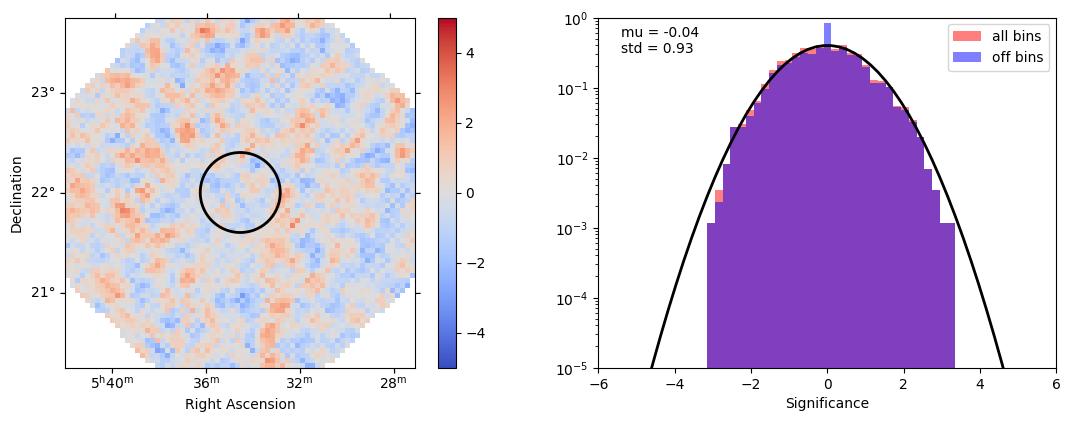

In [69]:
# The field is fairly flat, meaning the background estimation is good.
estimator = ExcessMapEstimator(correlation_radius=config['theta']*u.deg, correlate_off=False)
lima_maps = estimator.run(stacked)
plot_sig(lima_maps['sqrt_ts'], exclusion_mask_2d, 0.4*u.deg)

In [70]:
# One can repeat the same process as many as they want, however the quality of the mimic dataset
# (how much it resembles the on runs) will keep decreasing.
mimic.find_mimic_runs()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.18it/s]


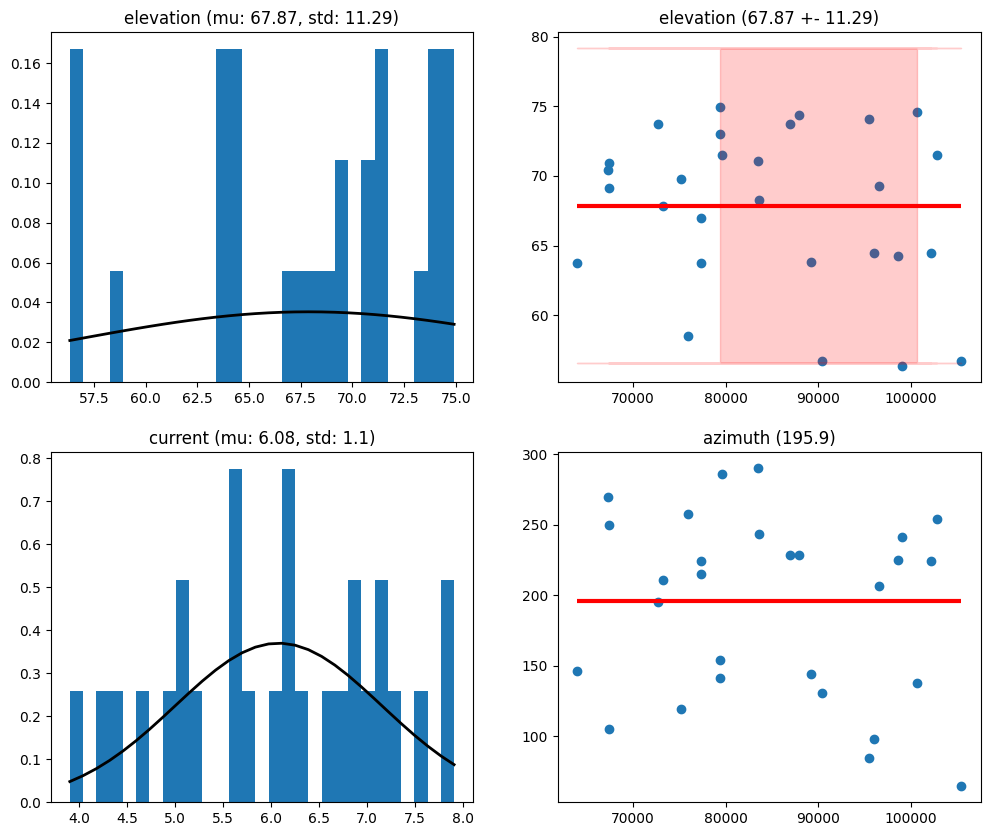

In [71]:
plot_runs_info(mimic.mimic_datasets[2]['information'])

In [72]:
mimic.run_blank_sky(2)
mimic.run_shifted_sky(2)

28it [00:30,  1.08s/it]
28it [00:10,  2.56it/s]


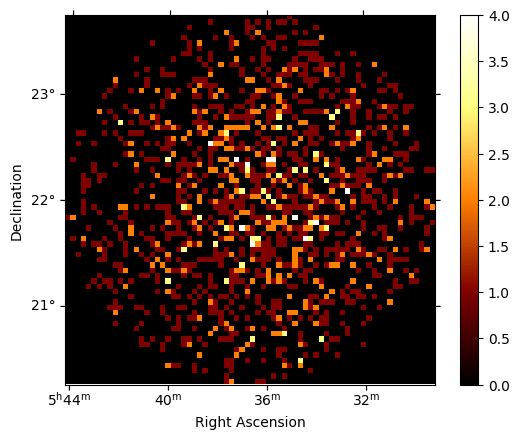

In [73]:
plot_obs(mimic.mimic_datasets[2]['observations'][0], add_cbar=True)

In [74]:
for idx, obs in tqdm(enumerate(mimic.mimic_datasets[2]['observations'])):
    mimic.mimic_datasets[2]['observations'][idx] = obs.copy(
        in_memory=True, events=select_gammas(obs), bkg=bkgrate)

28it [00:00, 33.70it/s]


In [75]:
stacked = MapDataset.create(geom, energy_axis_true=energy_axis_true, name='stacked')
datasets = datasets_maker.run(stacked, mimic.mimic_datasets[2]['observations'])

In [76]:
fov_bkg_maker = FoVBackgroundMaker(method='scale', exclusion_mask=exclusion_mask_1d)
for data in tqdm(datasets):
    dataset = fov_bkg_maker.run(data)
    stacked.stack(dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.73it/s]


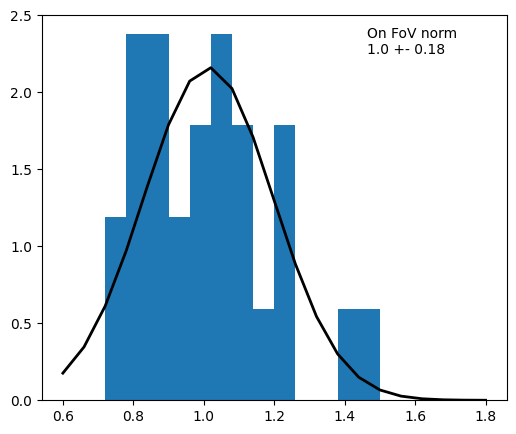

In [77]:
plot_fov([dataset.models[0].spectral_model.norm.value for dataset in datasets], 'On')

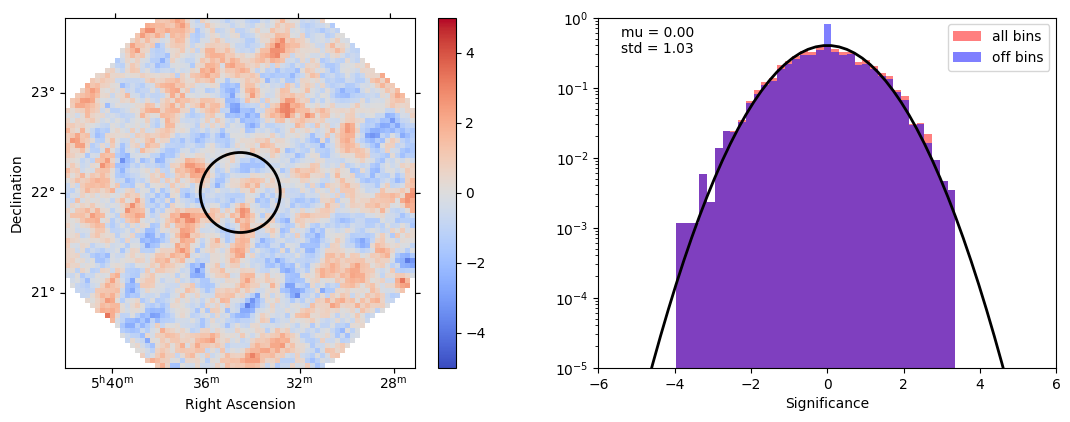

In [78]:
estimator = ExcessMapEstimator(correlation_radius=config['theta']*u.deg, correlate_off=False)
lima_maps = estimator.run(stacked)
plot_sig(lima_maps['sqrt_ts'], exclusion_mask_2d, 0.4*u.deg)